In [1]:
import dagshub
dagshub.init(repo_owner='Anmol25', repo_name='youtube-sentiment-analysis', mlflow=True)

import mlflow
mlflow.set_tracking_uri("https://dagshub.com/Anmol25/youtube-sentiment-analysis.mlflow")

Accessing as Anmol25

Initialized MLflow to track repo "Anmol25/youtube-sentiment-analysis"

Repository Anmol25/youtube-sentiment-analysis initialized!

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("data/merged/sentiments_undersampled.csv")
df.head()

,clean_comment,category
0,cant believe this modi,0
1,karachi under total blackout,0
2,what couldnt done years modi did years increas...,0
3,while modi talks about worlds tallest statue t...,-1
4,major announcement modi everyone was waiting f...,-1


In [3]:
df.dropna(inplace=True)

In [4]:
df.drop_duplicates(inplace=True)

In [5]:
df.isna().sum()

clean_comment    0
category         0
dtype: int64

In [7]:
df[df['clean_comment'].str.strip() == '']

,clean_comment,category


In [16]:
df[df['clean_comment'].str.strip() == '']

,clean_comment,category
708,,0
1529,,0
3510,,0
3905,,0
5798,,0
...,...,...
109570,,0
111575,,0
112810,,0
116382,,0


In [8]:
df = df[~(df['clean_comment'].str.strip() == '')]

In [9]:
df.isna().sum()

clean_comment    0
category         0
dtype: int64

In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [11]:
# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anmoljindal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anmoljindal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
# Define the preprocessing function
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [13]:
# Apply the preprocessing function to the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)

In [14]:
df.head()

,clean_comment,category
0,cant believe modi,0
1,karachi total blackout,0
2,couldnt done year modi year increasing unemplo...,0
3,modi talk world tallest statue talk world larg...,-1
4,major announcement modi everyone waiting game ...,-1


In [15]:
df.isna().sum()

clean_comment    0
category         0
dtype: int64

In [17]:
df = df[~(df['clean_comment'].str.strip() == '')]

In [18]:
df[df['clean_comment'].str.strip() == '']

,clean_comment,category


In [19]:
df.to_csv("data/preprocessed/sentiments_preprocessed.csv",index=False)

In [13]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Step 1: Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=2000)

In [15]:
X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category'] 

In [16]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(120000, 2000))

In [17]:
X.shape

(120000, 2000)

In [18]:
y

0         0
1         0
2         0
3        -1
4        -1
         ..
119995    1
119996    1
119997    1
119998   -1
119999   -1
Name: category, Length: 120000, dtype: int64

In [19]:
y.shape

(120000,)

In [20]:
# Set or create an experiment
mlflow.set_experiment("Undersampled Merged RF Baseline Model")

<Experiment: artifact_location='mlflow-artifacts:/1b2bcc72c90a4b40b373ed0954278c12', creation_time=1734950001408, experiment_id='3', last_update_time=1734950001408, lifecycle_stage='active', name='Undersampled Merged RF Baseline Model', tags={}>

2024/12/23 21:06:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run vaunted-skink-940 at: https://dagshub.com/Anmol25/youtube-sentiment-analysis.mlflow/#/experiments/3/runs/8791e15bf8bf4662bda4e4793a4adcfa
🧪 View experiment at: https://dagshub.com/Anmol25/youtube-sentiment-analysis.mlflow/#/experiments/3
Accuracy: 0.7029583333333334


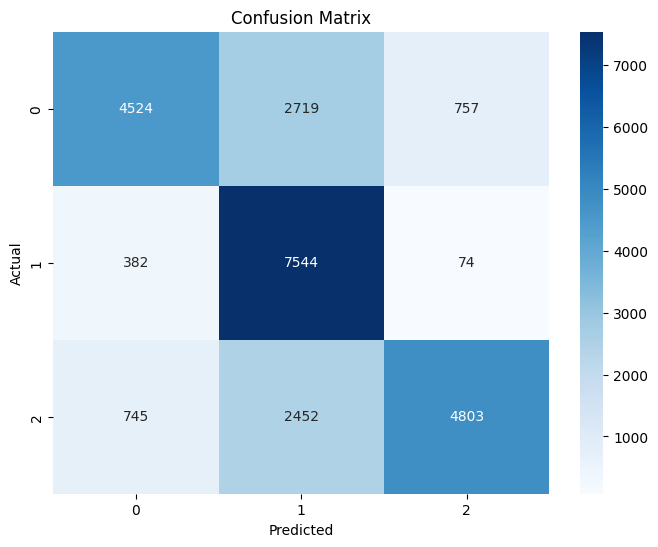

In [21]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Define and train a Random Forest baseline model using a simple train-test split
with mlflow.start_run() as run:
    # Log a description for the run
    # mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 150
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("content/confusion_matrix.png")
    mlflow.log_artifact("content/confusion_matrix.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # # Optionally log the dataset itself (if it's small enough)
    # df.to_csv("content/dataset.csv", index=False)
    # mlflow.log_artifact("content/dataset.csv")

# Display final accuracy
print(f"Accuracy: {accuracy}")

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.80      0.57      0.66      8000
           0       0.59      0.94      0.73      8000
           1       0.85      0.60      0.70      8000

    accuracy                           0.70     24000
   macro avg       0.75      0.70      0.70     24000
weighted avg       0.75      0.70      0.70     24000

